In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
import os
import tifffile as tf
from scipy import ndimage, stats
import utils
import math

def divisors(n):
    divs = [1]
    for i in range(2,int(math.sqrt(n))+1):
        if n%i == 0:
            divs.extend([i,n//i])
    divs.extend([n])
    return sorted(list(set(divs)))

In [2]:
fsrc = '../Bacteria Info for Erik/'
csrc = '../data/'
wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
sample = 'D2'

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))

ksrc += sample + os.sep

dst = fsrc

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col = 0)
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv')
tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))
transcriptomes = np.asarray(metatrans['gene'])

Cells = pd.read_excel(fsrc + 'Infected Cells w. Nuc.xlsx').values.squeeze()
cells = np.zeros_like(Cells)
for i in range(len(Cells)):
    cells[i] = metacell[metacell['orig_cellID'] == Cells[i]].index[0]

nuccutoff = 1
voronoi = tf.imread(nsrc + sample + '_EDT.tif')
nuclei = voronoi < nuccutoff

lnuc, nnuc = ndimage.label(nuclei, ndimage.generate_binary_structure(2,1))
nuc_area, _ = np.histogram(lnuc, bins=np.arange(nnuc + 2))
nuc_area[0] = 0
print('Detected',nnuc,'nuclei')

wall[nuclei] = False
wcoords = np.asarray(np.nonzero(~wall))
wallshape = wall.shape
wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

PP = 0
nuc_ratio = np.zeros(len(metacell), dtype=float)
for i in np.nonzero(metacell['nuclei_area'] > 100)[0]:
    cidx = metacell.iloc[i].name
    ss = (np.s_[max([0, metacell.loc[cidx, 'y0'] - PP]) : min([wall.shape[0], metacell.loc[cidx, 'y1'] + PP])],
          np.s_[max([1, metacell.loc[cidx, 'x0'] - PP]) : min([wall.shape[1], metacell.loc[cidx, 'x1'] + PP])])
    
    uq, ct = np.unique(lnuc[ss][(lnuc[ss] > 0) & (label[ss] == cidx)], return_counts=True)
    nuc_ratio[i] = np.max( ct/nuc_area[uq] )
print(np.sort(nuc_ratio[nuc_ratio > 0])[:20])
metacell['nuc_ratio'] = nuc_ratio

Detected 1365 nuclei
[0.03388125 0.03424869 0.04293381 0.04653938 0.05666667 0.05784732
 0.06028369 0.06859009 0.06884766 0.0827847  0.08359133 0.088812
 0.09387352 0.09497207 0.09678765 0.10160056 0.10214704 0.10338346
 0.10471491 0.1064204 ]


In [3]:
edt = np.zeros(voronoi.shape) - 1

for i in range(len(cells)):
    cell, cextent = utils.get_cell_img(cells[i], metacell, wall, label, pxbar=False)
    s_= np.s_[cextent[2]:cextent[3], cextent[0]:cextent[1]]

    cedt = np.ones(cell.shape, dtype=bool)
    cedt[ (nuclei[s_]) & (label[s_] == cells[i])] = False
    cedt = ndimage.distance_transform_edt(cedt)
    cedt[(label[s_] != cells[i])] = -1
    edt[s_][cedt > -1] = cedt[cedt > -1]

In [22]:
snuc = np.asarray(metacell[ (metacell['nuc_ratio'] > 0.35) | (metacell['c2t_area_ratio'] < 0.99) | (metacell['number_nuclei'] > 0) ].index)
np.intersect1d(snuc, cells)

array([ 150,  169,  216,  233,  235,  236,  267,  276,  290,  293,  294,
        301,  303,  305,  306,  314,  320,  325,  326,  331,  333,  336,
        341,  343,  344,  359,  366,  367,  369,  373,  375,  377,  383,
        395,  404,  405,  406,  420,  421,  426,  428,  433,  434,  437,
        439,  442,  443,  447,  455,  463,  464,  466,  468,  469,  475,
        476,  480,  482,  486,  490,  500,  501,  502,  511,  516,  522,
        523,  529,  535,  550,  556,  560,  575,  577,  579,  582,  586,
        595,  598,  606,  611,  612,  615,  618,  619,  626,  629,  632,
        644,  646,  652,  662,  671,  677,  680,  681,  683,  691,  693,
        694,  715,  721,  722,  727,  738,  742,  743,  745,  746,  750,
        751,  756,  758,  778,  783,  787,  790,  793,  795,  797,  800,
        805,  806,  810,  811,  813,  815,  817,  818,  824,  828,  837,
        839,  842,  845,  852,  859,  868,  873,  882,  893,  894,  896,
        900,  904,  908,  909,  910,  916,  921,  9

In [26]:
np.setdiff1d(cells, snuc)

array([ 424,  537,  649,  670,  703,  763,  816,  825,  853,  925,  941,
        943,  946,  965, 1033, 1034, 1036, 1159, 1254, 1275, 1343, 1463,
       1529, 1563, 1582, 1620, 1713, 1762, 1848, 1902, 1935, 2041, 2096,
       2364, 2448])

In [33]:
foo = metacell.loc[np.setdiff1d(cells, snuc), ['total_area','nuclei_area','cyto_area','c2t_area_ratio','number_nuclei', 'nuc_ratio']]
foo.sort_values(by='c2t_area_ratio', ascending=False)

,total_area,nuclei_area,cyto_area,c2t_area_ratio,number_nuclei,nuc_ratio
ndimage_cellID,,,,,,
1254,92521,16,92505,0.999827,0,0.000000
649,103597,25,103572,0.999759,0,0.000000
816,133304,33,133271,0.999752,0,0.000000
1036,69822,18,69804,0.999742,0,0.000000
1935,84167,22,84145,0.999739,0,0.000000
763,132097,36,132061,0.999727,0,0.000000
1529,72992,24,72968,0.999671,0,0.000000
2448,92973,31,92942,0.999667,0,0.000000
670,81870,30,81840,0.999634,0,0.000000


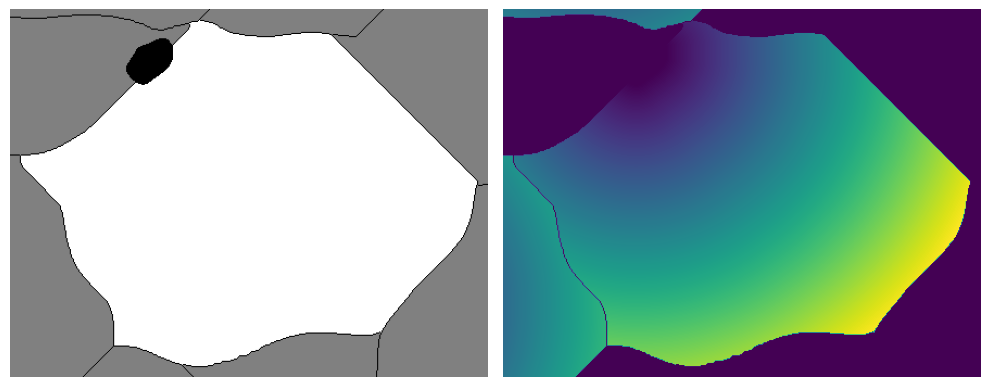

In [36]:
i = 941

cell, cextent = utils.get_cell_img(i, metacell, wall, label, pxbar=False)
s_= np.s_[cextent[2]:cextent[3], cextent[0]:cextent[1]]

fig, ax = plt.subplots( 1, 2, figsize=(10,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

ax[j].imshow(cell, cmap='binary_r', origin='lower', extent=cextent, vmin=0, vmax=2, zorder=1);
j += 1
ax[j].imshow(edt[s_], vmin=0, origin='lower', extent=cextent)
for j in range(len(ax)):
    ax[j].axis('off')

fig.tight_layout()

In [6]:
filename = csrc + sample + '_data/32771-slide1_' + sample + '_results.txt'
tlocs = pd.read_csv(filename, header=None, sep='\t').drop(columns=[4])
tlocs.columns = ['X', 'Y', 'Z', 'T']
cytlocs = tlocs.loc[ ~nuclei[ tlocs['Y'], tlocs['X'] ] ]
nulocs = tlocs.loc[ nuclei[ tlocs['Y'], tlocs['X'] ] ]
print(cytlocs.shape, nulocs.shape, tlocs.shape, sep='\t')

transcriptomes, invidx, tsize = np.unique(tlocs.loc[:,'T'], return_index = False, return_inverse=True, return_counts=True) 
tlocs = tlocs.loc[:, ['X','Y','Z']]
print('\nFound data for', len(transcriptomes), 'transcriptomes')

translocs = [None for i in range(len(transcriptomes))]
for tidx in range(len(transcriptomes)):
    translocs[tidx] = tlocs.loc[invidx == tidx]

#for i in range(len(transcriptomes)):
#    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
#    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
#tlocs = pd.concat(translocs)

zmax = 61
zmin = 1
Ns = divisors(zmax-zmin)[:-2]
Ns

(3702920, 4)	(127464, 4)	(3830384, 4)

Found data for 97 transcriptomes


[1, 2, 3, 4, 5, 6, 10, 12, 15, 20]

In [170]:
tidx = 2
nuct = translocs[tidx].loc[ nuclei[ translocs[tidx]['Y'], translocs[tidx]['X'] ] ]
cytt = translocs[tidx].loc[~nuclei[ translocs[tidx]['Y'], translocs[tidx]['X'] ] ]
print(nuct.shape, cytt.shape)

(22915, 3) (1797149, 3)


In [197]:
i = 389
tx,ty,tz = translocs[tidx].loc[label[ translocs[tidx]['Y'], translocs[tidx]['X'] ] == cells[i]].values.T
tedt = edt[ty, tx]
nx,ny,nz = nuct.loc[label[ nuct['Y'], nuct['X'] ] == cells[i]].values.T
cx,cy,cz = cytt.loc[label[ cytt['Y'], cytt['X'] ] == cells[i]].values.T
print(tz.shape, nz.shape, cz.shape)
np.setdiff1d(nz, cz)

(605,) (29,) (576,)


array([41])

SignificanceResult(statistic=-0.32875571647208546, pvalue=1.0285028658331151e-16)


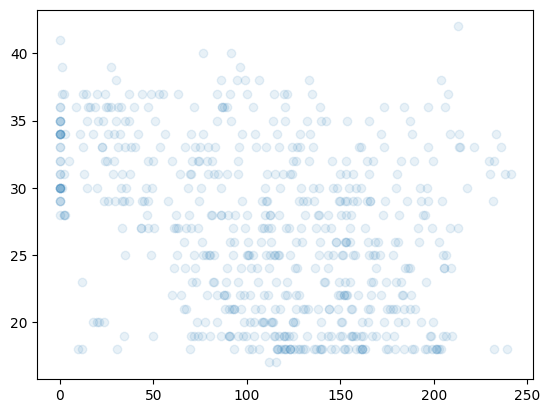

In [198]:
print(stats.spearmanr(tedt, tz))
plt.scatter(tedt, tz, alpha=0.1);

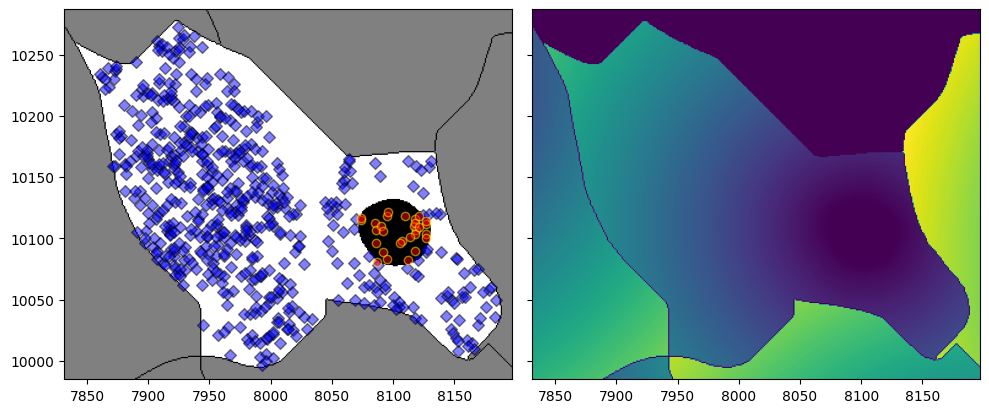

In [199]:
cell, cextent = utils.get_cell_img(cells[i], metacell, wall, label, pxbar=False)
s_= np.s_[cextent[2]:cextent[3], cextent[0]:cextent[1]]

fig, ax = plt.subplots( 1,2, figsize=(10,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

ax[j].imshow(cell, cmap='binary_r', origin='lower', extent=cextent, vmin=0, vmax=2, zorder=1);
ax[j].scatter(cx,cy, c='b', marker='D', edgecolor='k', alpha=0.5, zorder=2)
ax[j].scatter(nx,ny, c='r', marker='o', edgecolor='yellow', alpha=0.5, zorder=3)
ax[j].set_facecolor('#808080')

j += 1
ax[j].imshow(edt[s_], origin='lower', extent=cextent)

#for j in range(len(ax)):
#    ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.tight_layout();

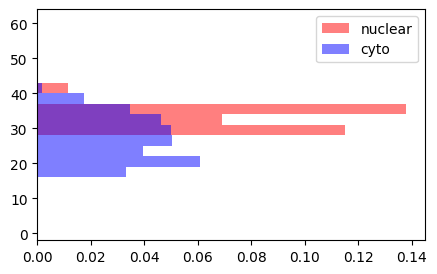

In [205]:
bins = np.arange(zmin, zmax+1, Ns[2])
hparams = {'bins':bins, 'alpha':0.5, 'density':True, 'orientation':'horizontal', 'zorder':2}

fig, ax = plt.subplots( 1,1, figsize=(5,3), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); j = 0

ax[j].hist(nz, color='r', label='nuclear', **hparams);
ax[j].hist(cz, color='b', label='cyto', **hparams)
ax[j].legend(fontsize=10, loc='upper right');

plt.savefig(dst + 'foo.jpg', bbox_inches='tight')

In [175]:
print(stats.ks_2samp(nz,cz,'less'), stats.ks_2samp(nz,cz,'greater'), sep='\n')

KstestResult(statistic=0.46788560712611343, pvalue=1.013636412965901e-16, statistic_location=23, statistic_sign=-1)
KstestResult(statistic=0.006592827004219409, pvalue=0.9889283300539461, statistic_location=37, statistic_sign=1)


In [176]:
print(stats.mannwhitneyu(nz, cz, True, 'greater'), stats.mannwhitneyu(nz, cz, True, 'less'), sep='\n')

MannwhitneyuResult(statistic=237642.5, pvalue=1.3144896430435431e-17)
MannwhitneyuResult(statistic=237642.5, pvalue=1.0)


In [190]:
data = np.zeros((len(cells), 10)) + 2

for i in range(len(cells)):
    tx,ty,tz = translocs[tidx].loc[label[ translocs[tidx]['Y'], translocs[tidx]['X'] ] == cells[i]].values.T
    tedt = edt[ty, tx]
    nx,ny,nz = nuct.loc[label[ nuct['Y'], nuct['X'] ] == cells[i]].values.T
    cx,cy,cz = cytt.loc[label[ cytt['Y'], cytt['X'] ] == cells[i]].values.T
    data[i, :2] = [len(nx), len(cx)]
    if len(nz) > 3:

        spearmanr = stats.spearmanr(tedt, tz)
        ksless = stats.ks_2samp(nz,cz,'less', method='asymp')
        ksgreater = stats.ks_2samp(nz,cz,'greater', method='asymp')
        mwgreater = stats.mannwhitneyu(nz, cz, True, 'greater', method='asymptotic')
        mwless = stats.mannwhitneyu(nz, cz, True, 'less', method='asymptotic')

        data[i, 2:] = [spearmanr.pvalue, spearmanr.statistic,
                       ksless.pvalue, ksless.statistic_location, 
                       ksgreater.pvalue, ksgreater.statistic_location, 
                       mwgreater.pvalue, mwless.pvalue]

In [191]:
columns = ['N_nuclear','N_cytosolic','spearman_pval', 'spearman_r',
           'ks_less_pval', 'ks_less_loc', 
           'ks_greater_pval', 'ks_greater_loc', 
           'mw_less_pval', 'mw_greater_pval']
df = pd.DataFrame(data, columns=columns, index=Cells)
df = df.astype({"N_nuclear":int, "N_cytosolic":int, "ks_less_loc":int, "ks_greater_loc":int})
df['index'] = range(len(df))
print(df.shape)
df.head()

(419, 11)


,N_nuclear,N_cytosolic,spearman_pval,spearman_r,ks_less_pval,ks_less_loc,ks_greater_pval,ks_greater_loc,mw_less_pval,mw_greater_pval,index
743,78,1685,1.071965e-03,-0.077838,6.152819e-10,28,0.252529,39,2.435586e-06,0.999998,0
843,95,3321,7.520509e-01,0.005407,9.753174e-01,37,0.000003,23,9.999872e-01,0.000013,1
2053,110,3230,5.029636e-01,-0.011594,1.834098e-13,28,0.968796,38,5.156586e-12,1.000000,2
896,42,3087,3.956040e-04,-0.063300,3.573121e-19,27,1.000000,40,5.062833e-20,1.000000,3
2153,105,3966,3.013104e-21,-0.147534,1.430623e-24,31,0.999103,44,2.263118e-28,1.000000,4


In [181]:
tol = 1e-1
foo = df[(df['ks_greater_pval'] > tol) & (df['ks_less_pval'] > tol) & (df['N_nuclear'] > 4)]
print(foo.shape)
foo.head()

(17, 10)


,N_nuclear,N_cytosolic,spearman_r,ks_less_pval,ks_less_loc,ks_greater_pval,ks_greater_loc,mw_less_pval,mw_greater_pval,index
1860,34,3145,0.953622,0.127282,18,0.103053,23,0.846628,0.153417,26
376,16,1188,0.000528,0.589547,41,0.252220,22,0.727119,0.273122,142
1758,13,3079,0.041573,0.456781,17,0.157979,26,0.562475,0.437648,145
1033,17,1327,0.001927,0.993031,21,0.353693,24,0.917058,0.083039,192
1645,5,2057,0.162922,0.969032,16,0.274696,19,0.810921,0.189284,242


In [180]:
foo = df[(df['ks_greater_pval'] < tol) & (df['ks_less_pval'] > tol) & (df['N_nuclear'] > 4)]
print(foo.shape)
foo.head()

(139, 10)


,N_nuclear,N_cytosolic,spearman_r,ks_less_pval,ks_less_loc,ks_greater_pval,ks_greater_loc,mw_less_pval,mw_greater_pval,index
843,95,3321,7.520509e-01,0.975317,37,3.260964e-06,23,0.999987,1.282193e-05,1
237,113,3709,3.412403e-02,0.621768,43,8.445502e-08,27,1.000000,8.193570e-08,7
811,91,2118,7.711822e-11,1.000000,44,3.689842e-07,29,1.000000,1.001650e-07,8
2065,126,4031,9.737126e-01,0.992767,20,2.065570e-08,30,1.000000,4.315144e-09,10
1776,41,1627,8.500228e-01,0.766820,37,2.547369e-11,19,1.000000,1.286629e-08,11


In [182]:
foo = df[(df['ks_greater_pval'] > tol) & (df['ks_less_pval'] < tol) & (df['N_nuclear'] > 4)]
print(foo.shape)
foo.head()

(141, 10)


,N_nuclear,N_cytosolic,spearman_r,ks_less_pval,ks_less_loc,ks_greater_pval,ks_greater_loc,mw_less_pval,mw_greater_pval,index
743,78,1685,1.071965e-03,6.152819e-10,28,0.252529,39,2.435586e-06,0.999998,0
2053,110,3230,5.029636e-01,1.834098e-13,28,0.968796,38,5.156586e-12,1.000000,2
896,42,3087,3.956040e-04,3.573121e-19,27,1.000000,40,5.062833e-20,1.000000,3
2153,105,3966,3.013104e-21,1.430623e-24,31,0.999103,44,2.263118e-28,1.000000,4
752,81,3792,1.808855e-04,6.050106e-16,23,0.988683,37,1.314490e-17,1.000000,5


In [183]:
foo = df[(df['ks_greater_pval'] < tol) & (df['ks_less_pval'] < tol) & (df['N_nuclear'] > 4)]
print(foo.shape)
foo.head()

(24, 10)


,N_nuclear,N_cytosolic,spearman_r,ks_less_pval,ks_less_loc,ks_greater_pval,ks_greater_loc,mw_less_pval,mw_greater_pval,index
1965,115,3085,7.828101e-01,0.001019,42,4.272959e-07,24,0.998151,0.001850,17
798,87,3023,7.377681e-01,0.000615,34,4.742673e-03,18,0.623275,0.376771,22
1620,103,2464,1.575329e-07,0.000057,34,2.034987e-06,20,0.860789,0.139242,34
932,76,2946,4.632084e-02,0.013206,33,4.208766e-05,20,0.997767,0.002234,39
1155,68,3455,9.570673e-05,0.023790,32,1.565728e-03,18,0.989533,0.010470,41


In [184]:
foo = df[ df['N_nuclear'] > 4]
print(foo.shape)
foo.head()

(321, 10)


,N_nuclear,N_cytosolic,spearman_r,ks_less_pval,ks_less_loc,ks_greater_pval,ks_greater_loc,mw_less_pval,mw_greater_pval,index
743,78,1685,1.071965e-03,6.152819e-10,28,0.252529,39,2.435586e-06,0.999998,0
843,95,3321,7.520509e-01,9.753174e-01,37,0.000003,23,9.999872e-01,0.000013,1
2053,110,3230,5.029636e-01,1.834098e-13,28,0.968796,38,5.156586e-12,1.000000,2
896,42,3087,3.956040e-04,3.573121e-19,27,1.000000,40,5.062833e-20,1.000000,3
2153,105,3966,3.013104e-21,1.430623e-24,31,0.999103,44,2.263118e-28,1.000000,4


In [185]:
df.to_csv(dst + transcriptomes[tidx] + '_kolmogorov_smirnov.csv', index=True, index_label='cell..I.D.')

In [196]:
df[df['spearman_r'] == -np.abs(df.loc[df['N_nuclear'] > 4, 'spearman_r'].values).max()]

,N_nuclear,N_cytosolic,spearman_pval,spearman_r,ks_less_pval,ks_less_loc,ks_greater_pval,ks_greater_loc,mw_less_pval,mw_greater_pval,index
1787,29,576,1.028503e-16,-0.328756,1.539537e-08,28,0.95632,36,1.450407e-07,1.0,389


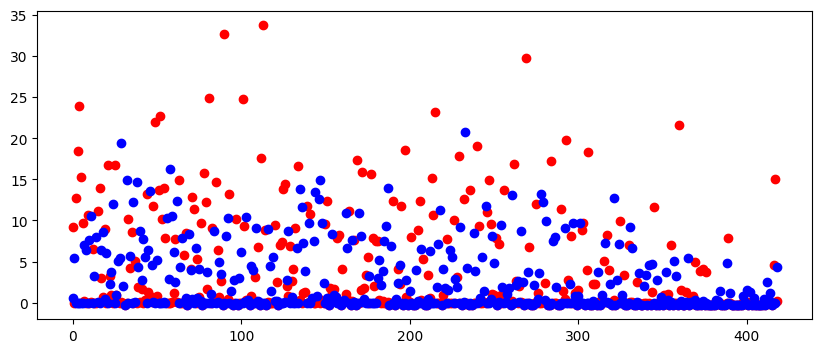

In [131]:
fig, ax = plt.subplots( 1,1, figsize=(10,4), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); j = 0

ax[j].scatter(range(len(cells)), -np.log10(df['ks_less_pval'].values), c='r')
ax[j].scatter(range(len(cells)), -np.log10(df['ks_greater_pval'].values), c='b');

In [63]:
tidx = 7
ttype = 'cytosolic'
coords = translocs[tidx].values.T

In [64]:
zcounts = [ np.zeros( (len(cells), (zmax - zmin)//Ns[i]), dtype=int) for i in range(len(Ns))]

for i in range(len(cells)):
    zcoords = translocs[tidx].loc[label[ coords[1], coords[0] ] == cells[i], 'Z'].values
    for j in range(len(Ns)):
        bins = np.arange(zmin, zmax+1, Ns[j])
        zhist, _ = np.histogram(zcoords, bins=bins)
        zcounts[j][i] = zhist

In [65]:
fs = 15
for j in range(len(Ns)):
    fig, ax = plt.subplots(1, 2,figsize=(10,5), sharex=False, sharey=True, width_ratios=[10,2])
    ax = np.atleast_1d(ax).ravel(); i=0
    ax[i].imshow(zcounts[j].T, origin='lower', cmap='inferno')
    ax[i].set_aspect(4*Ns[j])
    ax[i].set_xlabel('Infected cells w/ nucleus ('+ttype.title()+' transcripts)', fontsize=fs)
    ax[i].set_ylabel('Z-axis value', fontsize=fs)
    ax[i].set_yticks(np.arange((zmax-zmin)//Ns[j])-0.5, np.arange(zmin,zmax+1,Ns[j])[:-1])
    ax[i].set_title(transcriptomes[tidx] + ' (histogram bin width: {})'.format(Ns[j]), fontsize=fs)
    
    i+=1
    zhist = np.sum(zcounts[j], axis=0)/np.sum(zcounts[j])
    ax[i].plot(zhist, np.arange((zmax-zmin)//Ns[j]), c='b', marker='o', mfc='r')
    ax[i].set_xlabel('Proportion', fontsize=fs)
    ax[i].set_facecolor('snow')
    
    fig.tight_layout();
    filename = dst + transcriptomes[tidx] + '_' + ttype + '_histograms_{:04d}.png'.format(Ns[j])
    print(filename)
    plt.savefig(filename, format='png', dpi=200, bbox_inches='tight')
    plt.close()

../Bacteria Info for Erik/BAC52602_cytosolic_histograms_0001.png
../Bacteria Info for Erik/BAC52602_cytosolic_histograms_0002.png
../Bacteria Info for Erik/BAC52602_cytosolic_histograms_0003.png
../Bacteria Info for Erik/BAC52602_cytosolic_histograms_0004.png
../Bacteria Info for Erik/BAC52602_cytosolic_histograms_0005.png
../Bacteria Info for Erik/BAC52602_cytosolic_histograms_0006.png
../Bacteria Info for Erik/BAC52602_cytosolic_histograms_0010.png
../Bacteria Info for Erik/BAC52602_cytosolic_histograms_0012.png
../Bacteria Info for Erik/BAC52602_cytosolic_histograms_0015.png
../Bacteria Info for Erik/BAC52602_cytosolic_histograms_0020.png


In [66]:
with pd.ExcelWriter(dst + transcriptomes[tidx] + '_' + ttype + ".xlsx") as writer:
    for j in range(len(zcounts)):
        df = pd.DataFrame(zcounts[j], index=Cells, columns = np.arange(zmin, zmax+1, Ns[j])[:-1])
        df.to_excel(writer, index=True,index_label='cell..I.D.', sheet_name='{}'.format(Ns[j]) )

In [33]:
np.sum(Cells == 504)

0

# Deal with transcripts on the edge